In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler,Normalizer,MinMaxScaler, MaxAbsScaler,  LabelEncoder
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree, export_text
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb

from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import make_pipeline


from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout


import matplotlib.pyplot as plt

from ipywidgets import interact
import ipywidgets as widgets

%matplotlib inline

Using TensorFlow backend.


In [2]:
def get_poke_xy(dummies = True, label_encode = False, scaler = None, test_size = 0.3, random_state = 777, n_folds = 5):
    df = pd.read_csv("pokemon.zip", index_col = "Name")

    cat_cols = ["Type 1", "Type 2", "Generation"]
    num_cols = ['Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']
    target_col = "Legendary"
    drop_cols = ["#"]
    y_all = df[target_col].astype("int")
    
    X_all = df.drop(target_col , axis = 1)
    X_all.drop(drop_cols,axis=1, inplace = True)
    
    if label_encode:
        for c in cat_cols:
            try:
                X_all[c] = LabelEncoder().fit_transform(X_all[c].fillna("NaN"))
            except TypeError:
                print("could not encode: ", c)
    if dummies:
        X_all = X_all.drop(cat_cols, axis=1).join(pd.get_dummies(X_all[cat_cols].astype("category")))
    
    
    if scaler:
        sc = scaler()
        X_all[num_cols]  = sc.fit_transform(X_all[num_cols])
    
    kf = StratifiedKFold(n_splits = n_folds )
    folds = list(kf.split(X_all, y_all))
    
    return X_all, y_all, folds 

In [3]:
def train_model(X, y, folds, model = LogisticRegression, 
                model_params = {"penalty" :"l1", "solver" :"liblinear"}, 
                fit_params = None):
    
    colors = ["r","g", "b", "y", "c"]
    oof_preds = np.zeros(X.shape[0])
    scores = []
    models = []

    plt.subplots(figsize = (10, 10))
    #print(tgt, ":")
    plt.subplot(1, 1, 1)
    for i, (i_tr, i_te) in enumerate(folds):
        
        Xtr, Xte = X.iloc[i_tr], X.iloc[i_te]
        ytr, yte = y.iloc[i_tr], y.iloc[i_te]
        
        if model_params:
            mdl = model(**model_params)
        else: mdl = model()

        if fit_params:
            mdl.fit(Xtr, ytr, **fit_params)
        else:
            mdl.fit(Xtr, ytr)
    
        models.append(mdl)
        preds =  mdl.predict_proba(Xte)[:, 1]
        oof_preds[i_te] = preds
        score = roc_auc_score(yte, preds)
        scores.append(score)
        fpr, tpr, threshold = roc_curve(yte, preds)
        plt.plot(fpr, tpr, color = colors[i] , label = f"fold:{i}, AUC:{score:.3f}")
        
    plt.title(f"{model.__name__} AUC:{np.mean(scores):.3f}")
    plt.legend(loc=4)
    plt.show()
    return oof_preds, scores, models

In [4]:
X_all_lab, y_all_lab, folds  = get_poke_xy(dummies = False, label_encode=True)

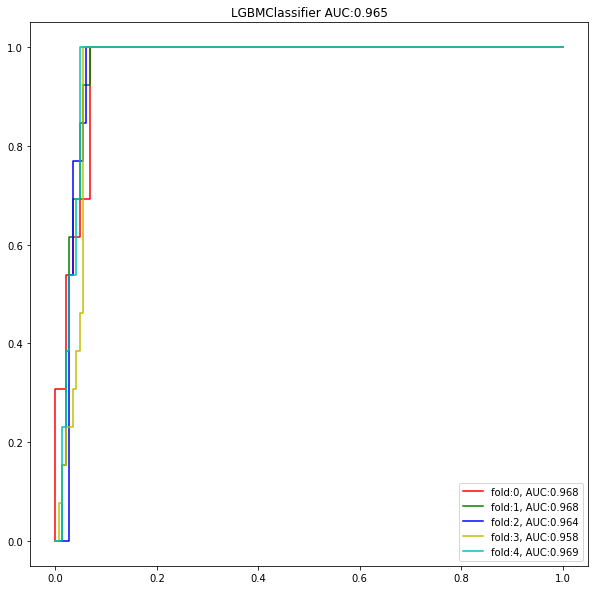

In [5]:
lgb_preds, lgb_scores, lgb_models = train_model(X_all_lab, y_all_lab, folds, model = lgb.LGBMClassifier, 
                                         model_params = {"n_estimators" : 500,
                                                         "learning_rate" : 0.01})

In [6]:
from interpret.ext.blackbox import TabularExplainer

In [7]:
Xtr = X_all_lab.iloc[folds[0][0],:]
ytr = y_all_lab.iloc[folds[0][0]]
Xte = X_all_lab.iloc[folds[0][1],:]
yte = y_all_lab.iloc[folds[0][1]]

explainer = TabularExplainer(lgb_models[0], 
                             Xtr, 
                             features=Xtr.columns.tolist())

In [8]:
global_explanation = explainer.explain_global(Xte)

In [9]:
from interpret_community.widget import ExplanationDashboard

In [10]:
ExplanationDashboard(global_explanation, lgb_models[0], datasetX=Xte)

ExplanationWidget(value={'predictedY': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…